In [20]:
import numpy as np
import pandas as pd

import os, glob, re, scipy.io
import matplotlib.pyplot as plt

from keras.preprocessing import image
from keras.models import Model

class GetStandfordCars:
    """
    
    
    """
    
    def __init__(self, loc="../Data/car_ims/", labels_matlab_file ="../Data/cars_annos.mat"):
        
        self.car_images_location = loc
        self.labels_mat = scipy.io.loadmat(labels_matlab_file)
        
        self.class_names = self.labels_mat['class_names'][0]
        
        self.max_pics = 16185
        
        # --- for future
        #  Code to check if the 'loc' is a valid dataset
        #  if not, download data and unzip
        #  same for the labels matlab file
        
    
    def bringAnnot(self, fileName):
        """
        """
        
        if type(fileName) == str:
            numb = int(re.sub(r'[^0-9]', '', fileName))
        else:
            numb = int(fileName)

        return ((self.labels_mat['annotations'][0][numb-1]))  
    

    def bringup_ClassLabel(self, fileName):
        if type(fileName) == str:
            numb = int(re.sub(r'[^0-9]', '', fileName))
        else:
            numb = int(fileName)

        #print("Class of image {}: {}".format(fileName, class_labels[int(mat['annotations'][0][numb-1][5])-1][0]))
        return self.class_names[int(self.labels_mat['annotations'][0][numb-1][5])-1][0]

    
    def getPath(self, number):
        fileName  = str('0') * int(6 - len(str(number)))
        fileName += str(number)+".jpg"
        return (self.car_images_location + fileName)

    
    def getImgArray(self, number, target_size=(224, 224) ):
        img_path =  self.getPath(number)
        img = image.load_img(img_path, target_size=target_size)
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        
        return x
    

    def getNextImgArray(self, target_size=(224, 224) ):
        count = 0
        
        while count<self.max_pics:
            count += 1        
        
            yield (count, self.getImgArray(count, target_size))
    

    def showRandomNxN(self, N):
        '''
        Function to plot the MNIST data on a grid of NxN
        '''
        plt.rcParams['figure.figsize'] = [30, 30]

        listofRand = np.random.randint(1, 16185, size=int(N*N))

        image_size = (128, 128)

        fig = plt.figure()

        for i in range(0, N*N):
            img = image.load_img(self.getPath(listofRand[i]), target_size=image_size)
            ax = fig.add_subplot(N, N, i+1)
            imgplot = ax.imshow(img)
            ax.set_title(self.bringup_ClassLabel(listofRand[i]))
            ax.grid(False)
            ax.set_xticks([])
            ax.set_yticks([])

        plt.show();

In [21]:
from keras.models import Model

from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input as vgg16_ppi
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input as vgg19_ppi
from keras.applications.resnet_v2 import ResNet50V2
from keras.applications.resnet_v2 import preprocess_input as Res50V2_ppi
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input as inceptv3_ppi
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.mobilenet_v2 import preprocess_input as moblv2_ppi

PRETRAINED_MODELS = {
    'VGG16': {
        'model': VGG16,
        'preprocess': vgg16_ppi,
        'shape': (224, 224)
    },
    'VGG19': {
        'model': VGG19,
        'preprocess': vgg19_ppi,
        'shape': (224, 224)
    },
    'ResNet50V2': {
        'model': ResNet50V2,
        'preprocess': Res50V2_ppi,
        'shape': (224, 224)
    },
    'InceptionV3': {
        'model': InceptionV3,
        'preprocess': inceptv3_ppi,
        'shape': (299, 299)
    },
    'MobileNetV2': {
        'model': MobileNetV2,
        'preprocess': moblv2_ppi,
        'shape': (224, 224)
    }
}

class GetPretrainedFeatures:
    """
    
    
    """
    
    def __init__(self, cnn="VGG16", database = GetStandfordCars(), layer = -1):
        
        self.cnn = cnn
        self.db = database
        self.layer_level = layer
        
    
    def get_pretrained_features(self, limit=20, folder = "../Data/features/"):
        
        feature_df = pd.DataFrame()
        
        model = PRETRAINED_MODELS[self.cnn]['model'](weights='imagenet', include_top=True)
        model_layer = Model(inputs=model.input, outputs=model.layers[self.layer_level].output)
        preprocess = PRETRAINED_MODELS[self.cnn]['preprocess']
        
        input_shape = PRETRAINED_MODELS[self.cnn]['shape']
        #print(input_shape)
        
        count = 0
        for img in self.db.getNextImgArray(target_size=input_shape):
            count += 1
            x = preprocess(img[1])
            features = model_layer.predict(x)
            features = [[img[0]] + list(np.ndarray.flatten(features))]
            feature_df = feature_df.append(pd.DataFrame(features), ignore_index=True)
            
            if count % 1000 == 0:
                feature_df.to_csv(folder + self.cnn + "_" + str(count//1000) + ".csv")
                feature_df = pd.DataFrame()
            
            if count == limit:
                    break
        
        if count != limit:
            feature_df.to_csv(folder + self.cnn + "_rest" + ".csv")
            
    

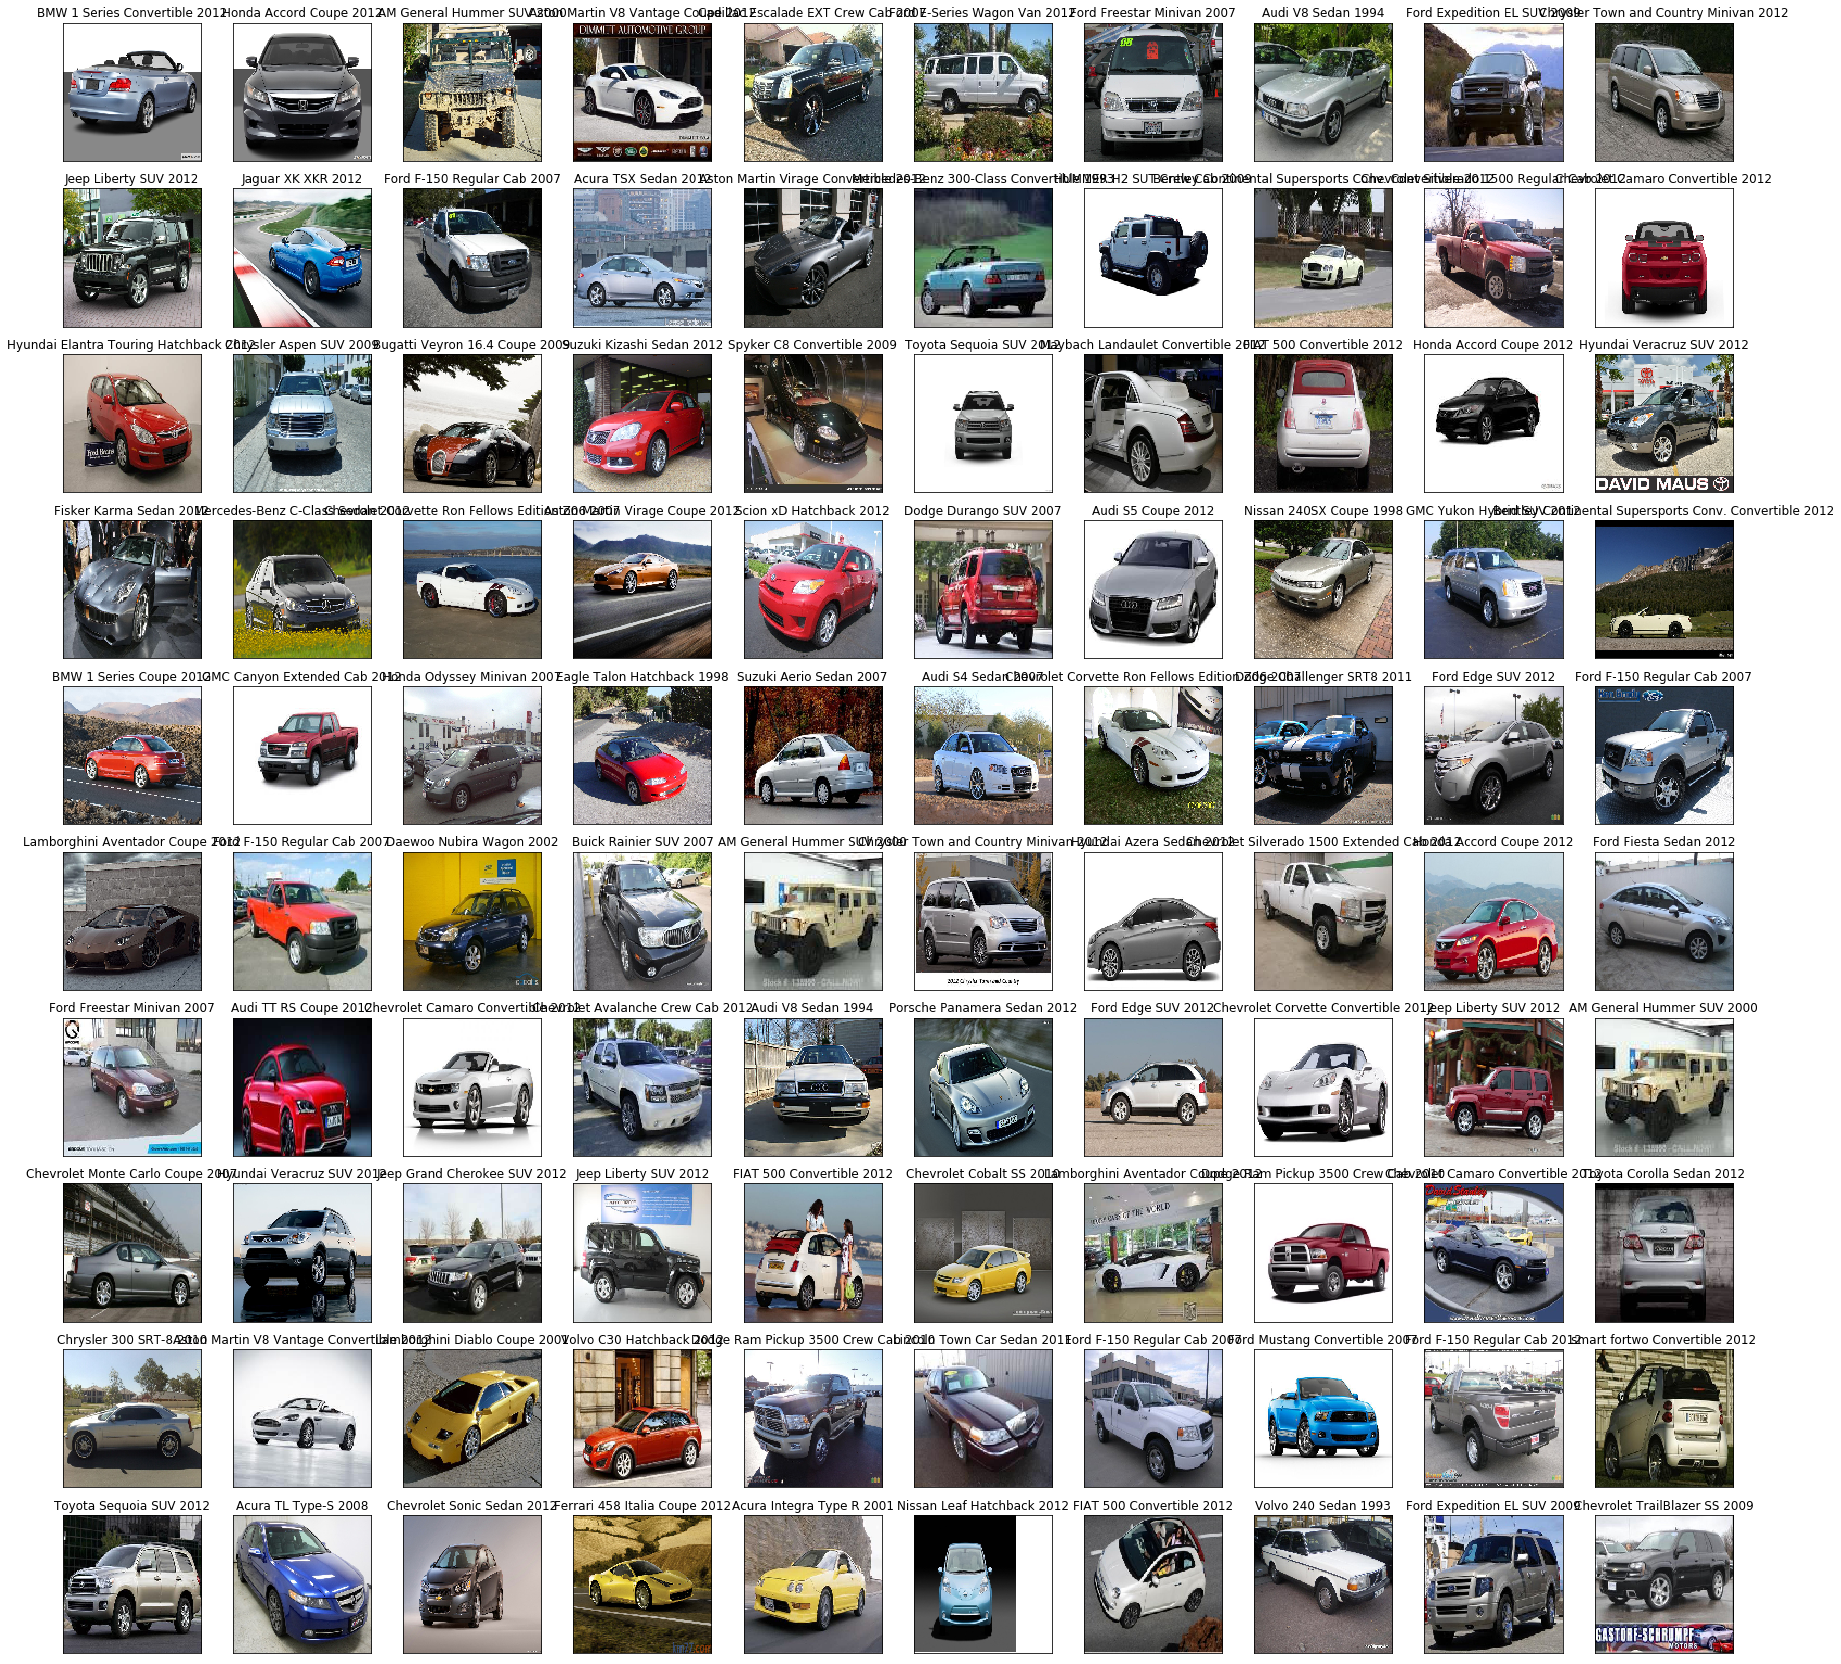

In [14]:
# --- Testing of GetStanfordCards Class
import matplotlib.pyplot as plt
%matplotlib inline

stan = GetStandfordCars()
stan.showRandomNxN(10)

In [23]:
limit_pics = 1000

#vgg16_pre = GetPretrainedFeatures(cnn="VGG16", layer = -2)
#vgg16_pre.get_pretrained_features(limit=limit_pics)

#vgg19_pre = GetPretrainedFeatures(cnn="VGG19", layer = -2)
#vgg19_pre.get_pretrained_features(limit=limit_pics)

#res50_pre = GetPretrainedFeatures(cnn="ResNet50V2", layer = -2)
#res50_pre.get_pretrained_features(limit=limit_pics)

inception_pre = GetPretrainedFeatures(cnn="InceptionV3", layer = -2)
inception_pre.get_pretrained_features(limit=limit_pics)

mbnet_pre = GetPretrainedFeatures(cnn="MobileNetV2", layer = -2)
mbnet_pre.get_pretrained_features(limit=limit_pics)